In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import joblib
import logging
import time
from pathlib import Path


logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
sns.set_style('darkgrid')

In [3]:
data_folder = Path('../data')
df_orig = pd.read_csv(data_folder / 'internet_service_churn.csv')
df_orig

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
72269,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1
72270,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1
72271,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1
72272,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1


##### Розділемо датасет на 2 частини:  
* одна для фінального тстування та завантаження в Streamlit - 500 рядків 
* друга буде використовуватися для аналізу та тренування моделей

In [4]:
df_final_test = df_orig.loc[:500,:].copy()
df_final_test.to_csv(data_folder / 'test_internet_service_churn.csv', index=False)
df = df_orig.loc[500:,:].copy()

In [16]:
df_final_test

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
496,10941,0,0,10.84,11,NaN,0,NaN,NaN,0,0
497,10977,1,1,10.83,22,NaN,0,20.2,2.2,0,0
498,11108,0,0,4.88,9,NaN,0,0.0,0.0,0,1
499,11120,0,0,6.38,0,NaN,0,0.2,0.0,0,1


##### Загальна інформація  по датасету

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71774 entries, 500 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71774 non-null  int64  
 1   is_tv_subscriber             71774 non-null  int64  
 2   is_movie_package_subscriber  71774 non-null  int64  
 3   subscription_age             71774 non-null  float64
 4   bill_avg                     71774 non-null  int64  
 5   reamining_contract           50553 non-null  float64
 6   service_failure_count        71774 non-null  int64  
 7   download_avg                 71408 non-null  float64
 8   upload_avg                   71408 non-null  float64
 9   download_over_limit          71774 non-null  int64  
 10  churn                        71774 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.0 MB


Бачимо що в деякіх колонках відсутні значення.   
5 ствбчик, що означає час до закінчення контракту та 7 і 8 стовбчики  - містить NaN значення.

Подивимось на іх кількість

In [5]:
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21221
service_failure_count              0
download_avg                     366
upload_avg                       366
download_over_limit                0
churn                              0
dtype: int64

Значення NaN в 5 стовбчику означає, що клієнт не укладав контракту з компанією.  
Додамо новий стовбчик 'contract', в якому позначимо - мав клієнт контракт (1) чи ні (0).  
Можна сказати, що ми додали нову feature для дослідження та прогнозування.

In [6]:
df

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
500,11138,0,0,5.87,0,NaN,0,0.0,0.0,0,1
501,11159,0,0,7.13,0,0.00,0,7.8,0.7,0,1
502,11164,1,0,4.28,13,NaN,0,0.0,0.0,0,1
503,11195,1,0,10.77,25,1.76,1,28.0,2.9,0,0
504,11266,1,1,10.76,20,1.26,0,181.1,5.2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
72269,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1
72270,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1
72271,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1
72272,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1


In [5]:
df['contract'] = df['reamining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)
df.insert(5, 'contract', df.pop('contract'))
df['reamining_contract'] = df['reamining_contract'].fillna(0)

Кількість значеннь NaN в стовбчиках 'download_avg' та 'upload_avg' становить менш ніж 0,5% від усіх значень.  
Видалимо  рядки з NaN значеннями - це не вплине суттєво на  загальні данні 

In [6]:
df.dropna(subset=['download_avg', 'upload_avg'], inplace=True, ignore_index=True)

##### Датасет виглядяє наступним чином:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71408 entries, 0 to 71407
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71408 non-null  int64  
 1   is_tv_subscriber             71408 non-null  int64  
 2   is_movie_package_subscriber  71408 non-null  int64  
 3   subscription_age             71408 non-null  float64
 4   bill_avg                     71408 non-null  int64  
 5   contract                     71408 non-null  int64  
 6   reamining_contract           71408 non-null  float64
 7   service_failure_count        71408 non-null  int64  
 8   download_avg                 71408 non-null  float64
 9   upload_avg                   71408 non-null  float64
 10  download_over_limit          71408 non-null  int64  
 11  churn                        71408 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 6.5 MB


##### Перевіримо данні на наявність дублікатів

In [18]:
df.duplicated(subset='id').sum()

0

##### Подивимось на статистичні данні

In [8]:
df.iloc[:, 1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,71408.0,0.817401,0.386340,0.00,1.00,1.00,1.00,1.00
is_movie_package_subscriber,71408.0,0.334724,0.471897,0.00,0.00,0.00,1.00,1.00
subscription_age,71408.0,2.414696,1.960942,-0.02,0.93,1.98,3.25,11.42
bill_avg,71408.0,19.030389,13.159953,0.00,13.00,19.00,22.00,406.00
contract,71408.0,0.703409,0.456758,0.00,0.00,1.00,1.00,1.00
reamining_contract,71408.0,0.499541,0.666329,0.00,0.00,0.00,1.03,2.92
service_failure_count,71408.0,0.275277,0.817090,0.00,0.00,0.00,0.00,19.00
download_avg,71408.0,43.834906,63.285856,0.00,6.90,28.00,60.70,4415.20
upload_avg,71408.0,4.207181,9.838175,0.00,0.50,2.10,4.90,453.30
download_over_limit,71408.0,0.208926,1.000077,0.00,0.00,0.00,0.00,7.00


##### Бачимо що:
* is_tv_subscriber - послугу IPTV  підключали більше 75% клієнтів
* subscription_age - 75% клієнтів компанії були підключені за останні 3 роки 
* bill_avg - 75% клієнтів компанії платять менше 22$
* reamining_contract - треба дослідити  

##### Подивимось більш детально. Виділимо ативних та неактивних клієнтів

In [9]:
alive = df[df['churn'] == 0]
die = df[df['churn'] == 1]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

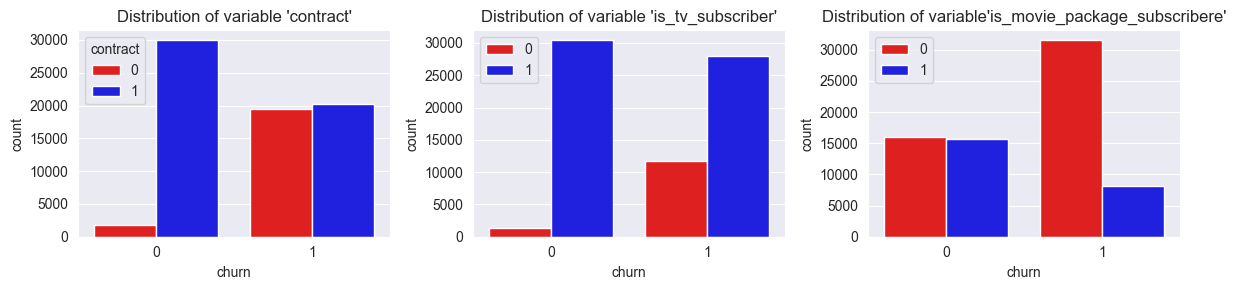

In [72]:
f, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.countplot(x='churn', hue='contract', data=df, ax=axs[0], palette=['r','b'])
axs[0].set_title("Distribution of variable 'contract'")

sns.countplot(x='churn', hue='is_tv_subscriber', data=df, ax=axs[1], palette=['r','b'])
axs[1].set_title("Distribution of variable 'is_tv_subscriber'")
axs[1].legend(loc="upper left")

sns.countplot(x='churn', hue='is_movie_package_subscriber', data=df, ax=axs[2], palette=['r','b'])
axs[2].set_title("Distribution of variable'is_movie_package_subscribere'")
axs[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

##### По графікам можна побачити:
1. Майже всі активні клієнти мають контракт, а в неактивних в половини його не було.
2. Більшість активних клієнтів підключені до послуг IPTV
3. Половина активних клієнтів мають доступ до відеотеки

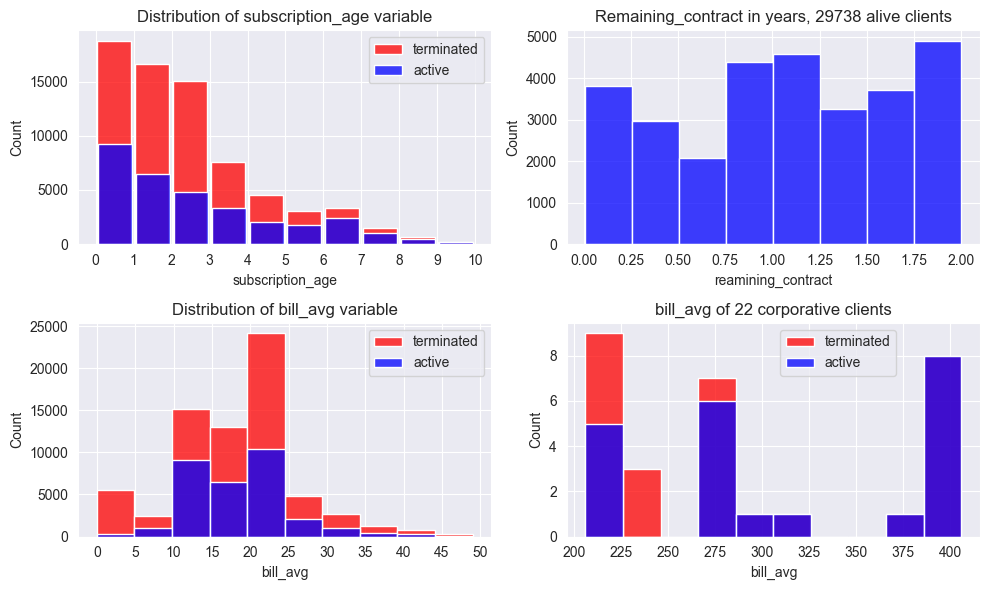

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

sns.histplot(df[df['subscription_age']<10]['subscription_age'], bins=10, color='r', ax=axs[0, 0], shrink=0.9, label='terminated')
sns.histplot(alive[alive['subscription_age']<10]['subscription_age'], bins=10, color='b', ax=axs[0, 0], shrink=0.9, label='active')
axs[0, 0].set_xticks(np.arange(0, 11, 1))
axs[0, 0].set_title("Distribution of subscription_age variable")
axs[0, 0].legend(loc="upper right")


reamining_contract = alive[(alive['reamining_contract']>0)&(alive['reamining_contract']<=2)]['reamining_contract']
sns.histplot(reamining_contract ,bins=8, color='b', ax=axs[0, 1])
axs[0, 1].set_title(f"Remaining_contract in years, {len(reamining_contract)} alive clients")

sns.histplot(df[df['bill_avg'] < 50]['bill_avg'], bins=10, color='r', ax=axs[1, 0], label='terminated')
sns.histplot(alive[alive['bill_avg'] < 50]['bill_avg'], bins=10, color='b', ax=axs[1, 0], label='active')
axs[1, 0].set_xticks(np.arange(0, 51, 5))
axs[1, 0].set_title("Distribution of bill_avg variable")
axs[1, 0].legend(loc="upper right")


corp_client = len(alive[alive['bill_avg'] >= 200]['bill_avg'])
sns.histplot(df[df['bill_avg'] >= 200]['bill_avg'], bins=10, color='r', ax=axs[1, 1], label='terminated')
sns.histplot(alive[alive['bill_avg'] >= 200]['bill_avg'], bins=10, color='b', ax=axs[1, 1], label='active')
axs[1, 1].set_title(f"bill_avg of {corp_client} corporative clients")
axs[1, 1].legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

plt.tight_layout()
plt.show()

##### По графікам можна побачити:
1.  За останні 2 роки зменшилась кількість нових клієнтів. До цього спостерігався значний приріст.  
Червоним позначено клієнтів які починали працювати {subscription_age} років назад і припинили користування
2. Як ми зазначали компанія має 30 000 активних клієнтів з контрактом.  
У майже 4000 клієнтів контракт закінчиться за 3 місяці 
3.  Більшість клієнтів (~55 000) сплачують в середньому від 10 до 25 $ за послуги, з них 26 000 активних
4.  З цікавого - команія має 22 клієнти які сплачують більше 200$, скоріш за все це корпоративні клієнти  

##### Подивимось як корелюють ознаки(features) та цільова ознака(target)

In [108]:
# styles = [dict(selector="th", props=[('width', '40px')]),
#             dict(selector="th.col_heading",
#                 props=[("writing-mode", "vertical-rl"),
#                         ('transform', 'rotateZ(180deg)'),
#                         ('vertical-align', 'middle'),
#                         ('text-align', 'left')
#                         ])]
# df_corr_styled = df_corr.set_table_styles(styles)

df_corr = df.iloc[:, 1:].corr().iloc[:-1,-1:].style.format("{:.2}")
df_corr.background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1, vmin=-1, vmax=1)

,churn
is_tv_subscriber,-0.33
is_movie_package_subscriber,-0.31
subscription_age,-0.14
bill_avg,-0.025
contract,-0.47
reamining_contract,-0.68
service_failure_count,0.02
download_avg,-0.3
upload_avg,-0.16
download_over_limit,0.16


Бачимо що ознаки "contract" та "reamining_contract" мають найбільшу кореляцю з цільовою ознакою.  
Вона від'ємна, тобто при зменшенні значення  однієї ознаки інша зростає.  
Скоріш за все вони будуть найважливіші при прогнозуванні.

##### По цим данним можна стверджувати що:
* чим менше часу до закінчення контракту [--> 0] тим БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]
* якщо нема підписаного контракту [0] то БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]
* чим менше вхідна швидкість мережі [--> 0] тим БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]
* якщо в клієнта немає підписки на IPTV чи відеотеку тим БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]  

Цікаво що довготривалість підиски (subscription_age) не дуже впливає на рішення клієнта припинити користування

----

##### Виділимо features та target

In [27]:
y = df['churn']
X = df.drop(columns=['churn','id'])

##### Подивимось на збалансованість данних

In [37]:
print(y.value_counts())

churn
1    39679
0    31729
Name: count, dtype: int64


##### Розділемо данні на тренувальну та тестову вибірки.  
Враховуючи що є незбалансованість вирішено примінити oversample метод  SMOTE(Synthetic Minority Oversampling Technique)  
Для стандартизації данних будемо використовувати метод StandardScaler

In [45]:
x_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
print(np.unique(Y_train, return_counts=True))

(array([0, 1], dtype=int64), array([23797, 29759], dtype=int64))


In [82]:
oversample = SMOTE()
scaler = StandardScaler()

X_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, Y_train)
X_train_scaled_oversampled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(x_test)

X_train = X_train_scaled_oversampled
X_test = X_test_scaled
y_train = y_train_oversampled

print(np.unique(y_train, return_counts=True))

print('train X', X_train.shape)
print('train y', y_train.shape)
print('test X', X_test.shape)
print('test y', y_test.shape)

(array([0, 1], dtype=int64), array([29759, 29759], dtype=int64))
train X (59518, 10)
train y (59518,)
test X (17852, 10)
test y (17852,)


Бачимо що тепер кількість данних для обох класів d тренувальній вибірці однакова

Збережемо SCALER в файл для можливості подальшого використання

In [15]:
joblib.dump(scaler,'../models/std_scaler_Serhii.pkl')

['../models/std_scaler_Serhii.pkl']

----

## Побудова моделей

##### Функція аналізу роботи моделей

In [16]:
def model_info(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of LR : {accuracy}")
    print('\n','-'*50)
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    print('\n','-'*50)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=900, vmax=6000)
    plt.title('Confusion matrix')
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()

Підбирати найкращі гіперпараметри будемо за допомогою GridSearchCV

### Logistic regression

In [ ]:
lr_start_time = time.time()

LR = LogisticRegression(random_state=42)
param_grid = {'penalty':[None, 'l1', 'l2'],
              'C': [0.01, 0.001], 
              'max_iter':[20, 25, 30], 
              'solver': ['lbfgs', 'liblinear']
              }

logisticRegression = GridSearchCV(LR, param_grid, cv=3, refit=True, return_train_score=True, n_jobs=1)
logisticRegression.fit(X_train, y_train)
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

lr_model = logisticRegression.best_estimator_

y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
lr_end_time = time.time()-lr_start_time
print(f'Build Logistic Regression model time: {lr_end_time:.2f} secs')

In [73]:
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

Logistic Regression best parameters: {'C': 0.001, 'max_iter': 20, 'penalty': 'l2', 'solver': 'liblinear'}


##### Статистика роботи моделі LogisticRegression на тестувальних данних 

Accuracy of LR : 0.8828702666367914

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7932
           1       0.89      0.90      0.90      9920

    accuracy                           0.88     17852
   macro avg       0.88      0.88      0.88     17852
weighted avg       0.88      0.88      0.88     17852


 --------------------------------------------------


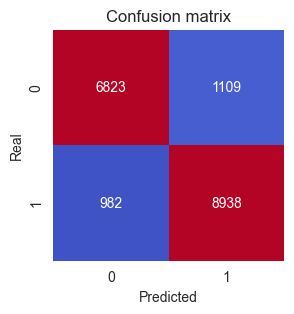

In [84]:
model_info(y_test, y_pred_lr)

Точність 88% не дуже гарний результат, але швидкість 6 секунд для всього процесу аналізу. Збережемо модель.

In [63]:
joblib.dump(lr_model,'../models/LR_model_Serhii.pkl')

['../models/LR_model_Serhii.pkl']

### LinearSVC

In [85]:
SVC = LinearSVC(random_state=42)

svc_start_time = time.time()
param_grid = {'C': [0.01, 0.1, 1], 'tol':[1e-4, 1e-05], 'max_iter':[1000, 10000]}
linearSVC = GridSearchCV(SVC, param_grid, cv=3, return_train_score=True, n_jobs=1)

linearSVC.fit(X_train, y_train)
print(f'LinearSVC best parameters: {linearSVC.best_params_}')

svc_model = linearSVC.best_estimator_
y_pred_svc = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

svc_end_time = time.time()-svc_start_time
print(f'Build LinearSVC model time: {svc_end_time:.2f} secs')

LinearSVC best parameters: {'C': 0.01, 'max_iter': 1000, 'tol': 0.0001}
Build LinearSVC model time: 4.84 secs


##### Статистика роботи моделі LinearSVC на тестувальних данних 

Accuracy of LR : 0.8797893793412502

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7932
           1       0.88      0.91      0.89      9920

    accuracy                           0.88     17852
   macro avg       0.88      0.88      0.88     17852
weighted avg       0.88      0.88      0.88     17852


 --------------------------------------------------


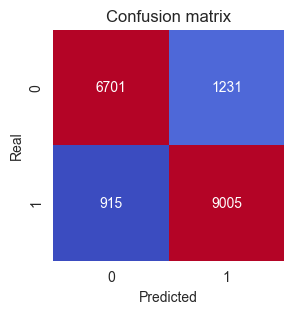

In [86]:
model_info(y_test, y_pred_svc)

Точність 88% як у Logistic Regression, але помилкових передбачень у класі '1' менше на 67 штук.  
Тобто модель трохи краще передбачила проблемних клієнтів.  
Збережемо модель.

In [62]:
joblib.dump(svc_model,'../models/SVC_model_Serhii.pkl')

['../models/SVC_model_Serhii.pkl']

----

### RandomForest

In [64]:
RF = RandomForestClassifier(random_state=42)

rf_start_time = time.time()
param_grid = {'n_estimators': [50, 100, 200], 'max_features':['sqrt', 'log2']}
RandomForest = GridSearchCV(estimator=RF, param_grid=param_grid, scoring='f1', cv=2, return_train_score=True, n_jobs=1, verbose=3)

RandomForest.fit(X_train, y_train)
print(f'RandomForest best parameters: {RandomForest.best_params_}')

rf_model = RandomForest.best_estimator_
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

rf_end_time = time.time()-rf_start_time
print(f'Build RandomForest model time: {rf_end_time:.2f} secs')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=50;, score=(train=1.000, test=0.940) total time=   3.6s
[CV 2/2] END max_features=sqrt, n_estimators=50;, score=(train=1.000, test=0.944) total time=   2.8s
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.941) total time=   6.9s
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.944) total time=   5.4s
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.940) total time=  15.9s
[CV 2/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.945) total time=  13.7s
[CV 1/2] END max_features=log2, n_estimators=50;, score=(train=1.000, test=0.940) total time=   3.0s
[CV 2/2] END max_features=log2, n_estimators=50;, score=(train=1.000, test=0.944) total time=   2.6s
[CV 1/2] END max_features=log2, n_estimators=100;, score=(train=1.000, test=0.941) total time=   7.2s
[CV 2/2] END max_features=

##### Статистика роботи моделі на тестувальних данних

Accuracy of LR : 0.9397826574053327

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      7932
           1       0.96      0.93      0.94      9920

    accuracy                           0.94     17852
   macro avg       0.94      0.94      0.94     17852
weighted avg       0.94      0.94      0.94     17852


 --------------------------------------------------


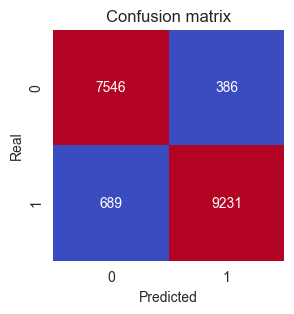

In [66]:
model_info(y_test, y_pred_rf)

Отримаємо чудовий результат 94% точності на тестувальній вибірці. Збережемо модель.

In [67]:
joblib.dump(rf_model,'../models/RF_model_Serhii.pkl', compress=3)

['../models/RF_model_Serhii.pkl']

##### Важливість ознак в датасеті для отриманої моделі

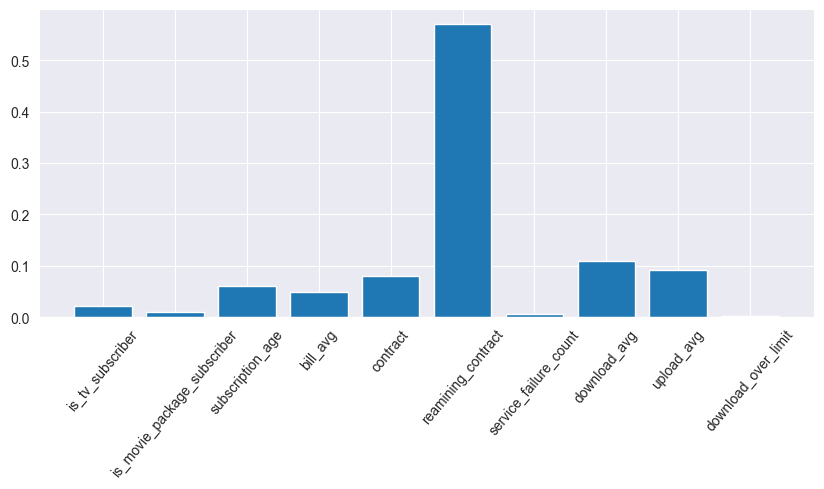

In [111]:
plt.figure(figsize=(10,4))
plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.xticks(range(len(df.columns[1:-1])), df.columns[1:-1], rotation=50);

----

### Basic Neural Network

##### Побудуємо просту нейронну мережу.  
Розмірність данних змінемо за допомогою MinMaxScaler

In [46]:
min_max_scaler = MinMaxScaler()

min_max_scaler.fit_transform(X)
X_train = min_max_scaler.transform(x_train)
X_test_nn = min_max_scaler.transform(x_test)
y

In [48]:
model_NN = Sequential()
model_NN.add(Dense(128, input_dim=10, activation='relu'))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(64, activation='relu'))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(1, activation='sigmoid'))

model_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_NN.summary()

nn_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
history = model_NN.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

score = model_NN.evaluate(X_test_nn, y_test, verbose=0)

y_pred_nn = model_NN.predict(X_test_nn)

nn_end_time = time.time()-nn_start_time
print(f'Build NN model time: {nn_end_time:.2f} secs')

c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8229 - loss: 0.4349 - val_accuracy: 0.8938 - val_loss: 0.3011
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8968 - loss: 0.3014 - val_accuracy: 0.9024 - val_loss: 0.2804
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9107 - loss: 0.2739 - val_accuracy: 0.9072 - val_loss: 0.2731
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9129 - loss: 0.2612 - val_accuracy: 0.9113 - val_loss: 0.2595
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9176 - loss: 0.2526 - val_accuracy: 0.9160 - val_loss: 0.2499
Epoch 6/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9201 - loss: 0.2489 - val_accuracy: 0.9171 - val_loss: 0.2472
Epoch 7/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9217 - loss: 0.2445 - val_accuracy: 0.9201 - val_loss: 0.2407
Epoch 8/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9216 - loss: 0.2411 - val_accuracy: 0.

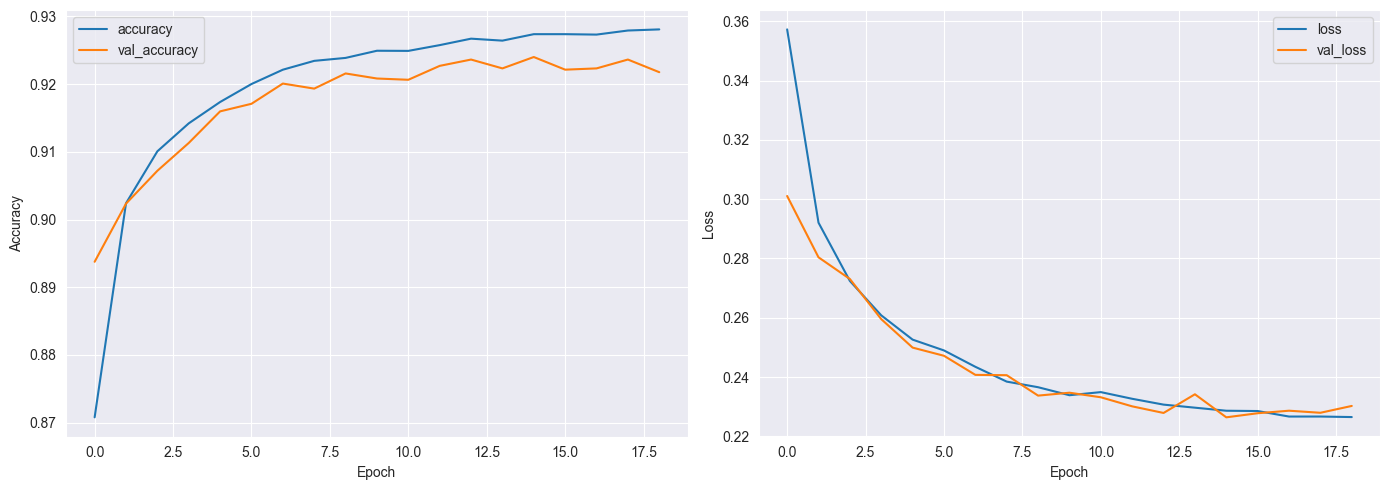

In [49]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Статистика роботи моделі на тестувальних данних

Accuracy of LR : 0.9300918664575397

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      7932
           1       0.95      0.92      0.94      9920

    accuracy                           0.93     17852
   macro avg       0.93      0.93      0.93     17852
weighted avg       0.93      0.93      0.93     17852


 --------------------------------------------------


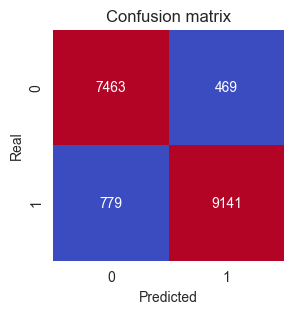

In [31]:
binary_predictions = [1 if p > 0.5 else 0 for p in y_pred_nn]

model_info(y_test, binary_predictions)

Збережемо модель та скейлер

In [32]:
joblib.dump(model_NN,'../models/NN_model_Serhii.pkl')
joblib.dump(min_max_scaler,'../models/NN_scaler_Serhii.pkl')

['../models/NN_scaler_Serhii.pkl']

### Порівняємо роботу різних моделей

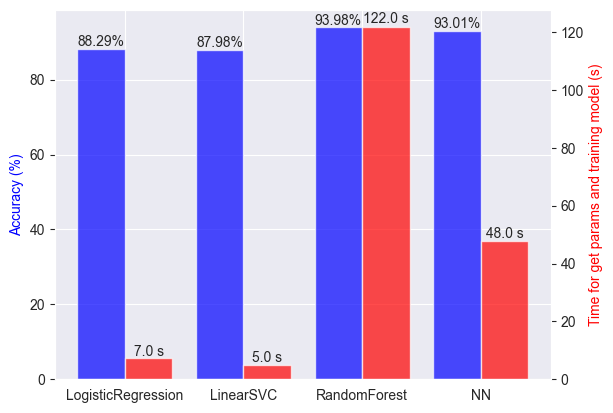

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


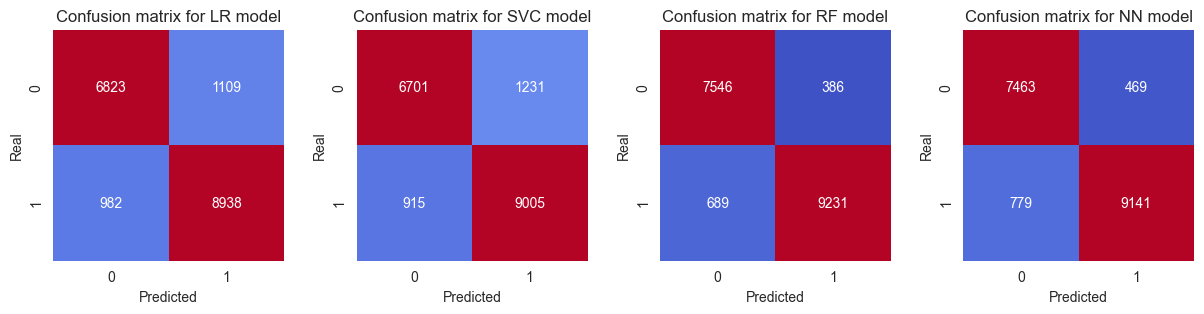

In [102]:
data = {'model':['LogisticRegression','LinearSVC', 'RandomForest', 'NN'],
        'analyze_time':[lr_end_time, svc_end_time, rf_end_time, nn_end_time],
        'accuracy':[accuracy_lr*100, accuracy_svc*100, accuracy_rf*100 ,score[1]*100]}

pred = {'LR':y_pred_lr, 'SVC':y_pred_svc, 'RF':y_pred_rf, 'NN':y_pred_nn}

df_results = pd.DataFrame(data)

fig, ax= plt.subplots()
ax2 = ax.twinx()
width = 0.4

x = np.array([i for i,_ in enumerate(df_results['model'])])

ax.bar(x - width/2, df_results['accuracy'], color='b', alpha=0.7, width=width)
ax2.bar(x + width/2, df_results['analyze_time'], color='r', alpha=0.7, width=width)

plt.xticks(range(len(df_results['model'])), df_results['model'], rotation=0);
ax.set_ylabel('Accuracy (%)', color='b')
ax2.set_ylabel('Time for get params and training model (s)', color='r')

for i, v in enumerate(df_results['accuracy'].round(2)):
    ax.text(i-0.2, v, str(v)+'%', ha='center', va='bottom')

for i, v in enumerate(df_results['analyze_time'].round()):
    ax2.text(i+0.2, v, str(v)+' s', ha='center', va='bottom')

plt.grid()
plt.show()


plt.figure(figsize=(15, 3))
for i, (m, p) in enumerate(pred.items()):
    cm = confusion_matrix(y_test, p)
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=300, vmax=6700)
    plt.title(f'Confusion matrix for {m} model')
    plt.ylabel('Real')
    plt.xlabel('Predicted')
plt.show()